In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')
from scipy.signal import butter, lfilter, freqz
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [35]:
pd.set_option('display.max_rows',100)

In [36]:
path = '/content/drive/MyDrive/sisfall_data/'
person = ['SA01','SA02','SA03','SA04','SA05','SA06','SA07','SA08','SA09','SA10','SA11','SA12','SA13','SA14','SA15','SA16','SA17','SA18','SA19','SA20','SA21','SA22','SE01','SE02','SE03','SE04','SE05','SE08','SE09']
          #  'SA11','SA12','SA13','SA14','SA15','SA16','SA17','SA18','SA19','SA20',   'SE01','SE02','SE03','SE04','SE05','SE06','SE07'

person2 = ['SA21','SA22','SA23','SE08','SE09','SE10']

In [37]:
# dailies = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',
#            'D16', 'D17', 'D18', 'D19']
dailies = []
#  , 'D05','D07', 'D08', 'D09', 'D10'
falls = ['F01', 'F02', 'F03', 'F04']
#  ,'F10','F11', 'F12', 'F13', 'F14', 'F15'
# falls = ['F01', 'F02', 'F03', 'F04']
trials = ['R01','R02','R03','R04','R05']

label_sizes = [160]
WINDOWSIZEs = [60]
min_maxs = [0]
## check_list 안에 standard 있어야함

check_lists = [['vm2','g_sum','diff_sum']]## check_list 안에 standard 있어야함
standard = 'vm2'

####특성 : sum vector magnitude, sum gyro magnitude, 9 Standard deviation magnitude
|train data|test data|test_acc|
|------|---|---|
|성인 20명|성인3명, 노인 3명 |acc: 0.89, recall:0.85,prec:0.99, f1:0.92|
|성인 15명, 노인 5명|성인 3명, 노인 3명|테스트3|

In [38]:

# Filter requirements.
order = 4
fs = 200.0  # sample rate, Hz
cutoff = 5.0  # desired cutoff frequency of the filter, Hz


# From??????
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [39]:
def printer(df, min_max=True, range=[0,3000], *args):
    idx = {}
    if min_max:
        x = df.drop(['activity','person'],axis=1).astype('float64')
        k = (x - x.min()) / (x.max() - x.min())
        for w in args:
            plt.plot(k[w],label=w)
            idx[w] = df[w][df[w] == df[w].max()].index.values
        plt.title(f'person:{df.person[0]}  ,  activity:{df.activity[0]}')
        plt.xlim(range)
        plt.legend()
        plt.show()
        for w in idx:
            print(f'{w} : {idx[w]}')
    else:
        for w in args:
            plt.plot(df[w],label=w)
        plt.title(df.activity[0])
        plt.xlim(range)
        plt.legend()
        plt.show()

In [40]:
def preprocess(person):
    subjectList = []
    adl_list = []
    fall_list = []
    for man in person:
        a = pd.read_csv(path + f'{man}.csv')
        df = a[['ADXL_x', 'ADXL_y', 'ADXL_z', 'ITG_x', 'ITG_y', 'ITG_z', 'subject', 'activity', 'trial']]
        # df['ADXL_x'] *= (32/8192)
        # df['ADXL_y'] *= (32/8192)
        # df['ADXL_z'] *= (32/8192)
        df['ITG_x'] *= (1000/(2**17))
        df['ITG_y'] *= (1000/(2**17))
        df['ITG_z'] *= (1000/(2**17))
        subjectList.append(df)
    for s in subjectList:
        for d in dailies:
            tempdf = s[s['activity'] == d]
            adl_list.append(tempdf)

        for f in falls:
            tempdf = s[s['activity'] == f]
            fall_list.append(tempdf)
            
    return fall_list, adl_list
    

In [41]:
def preprocess2(df , check_list):
    df_list = []
    rol_val = 200
    for my_df in df:
        for trial in trials:
            trial_df = my_df[my_df['trial'] == trial]
            if len(trial_df) == 0:
                continue
            trial_df.reset_index(inplace=True)
            tempdf = pd.DataFrame()
            tempdf['ax'], tempdf['ay'], tempdf['az'] = trial_df['ADXL_x'], trial_df['ADXL_y'], trial_df['ADXL_z']
            tempdf['fx'] = pd.Series(butter_lowpass_filter(trial_df['ADXL_x'], cutoff, fs, order))
            tempdf['fy'] = pd.Series(butter_lowpass_filter(trial_df['ADXL_y'], cutoff, fs, order))
            tempdf['fz'] = pd.Series(butter_lowpass_filter(trial_df['ADXL_z'], cutoff, fs, order))
            tempdf['vs'] = np.sqrt(tempdf['ax'] ** 2 + tempdf['ay'] ** 2 + tempdf['az'] ** 2)
            tempdf['vm2'] =np.sqrt(tempdf['fx'] ** 2 + tempdf['fy'] ** 2 + tempdf['fz'] ** 2)

            tempdf['bx'] = tempdf['fx'].diff()
            tempdf['by'] = tempdf['fy'].diff()
            tempdf['bz'] = tempdf['fz'].diff()
            tempdf['diff_sum'] = np.sqrt(tempdf['bx'] ** 2 + tempdf['by'] ** 2 + tempdf['bz'] ** 2)
            # tempdf['activity'] = trial_df['activity']
            # tempdf['person'] = trial_df['subject']
            tempdf['gx'], tempdf['gy'], tempdf['gz'] = trial_df['ITG_x'], trial_df['ITG_y'], trial_df['ITG_z']
            tempdf['g_fx'] = pd.Series(butter_lowpass_filter(tempdf['gx'], cutoff, fs, order))
            tempdf['g_fy'] = pd.Series(butter_lowpass_filter(tempdf['gy'], cutoff, fs, order))
            tempdf['g_fz'] = pd.Series(butter_lowpass_filter(tempdf['gz'], cutoff, fs, order))
            tempdf['g_sum'] = np.sqrt(tempdf['g_fx'] ** 2 + tempdf['g_fy'] ** 2 + tempdf['g_fz'] ** 2)
            tempdf['g_sum2'] = np.sqrt(tempdf['gx'] ** 2 + tempdf['gy'] ** 2 + tempdf['gz'] ** 2)




            #Rolling standard deviations
            tempdf['bx_std'] = tempdf['bx'].rolling(rol_val,min_periods = 1).std()
            tempdf['by_std'] = tempdf['by'].rolling(rol_val,min_periods = 1).std()
            tempdf['bz_std'] = tempdf['bz'].rolling(rol_val,min_periods = 1).std()
            tempdf['fx_std'] = tempdf['fx'].rolling(rol_val,min_periods = 1).std()
            tempdf['fy_std'] = tempdf['fy'].rolling(rol_val,min_periods = 1).std()
            tempdf['fz_std'] = tempdf['fz'].rolling(rol_val,min_periods = 1).std()
            tempdf['gx_std'] = tempdf['gx'].rolling(rol_val,min_periods = 1).std()
            tempdf['gy_std'] = tempdf['gy'].rolling(rol_val,min_periods = 1).std()
            tempdf['gz_std'] = tempdf['gz'].rolling(rol_val,min_periods = 1).std()

            # had to make versions of this to put into sliding window, will change once I
            # confirm they're the same as the others below
            #C8
            tempdf['horiz_std_mag9'] = np.sqrt(tempdf['fx_std'] ** 2 + tempdf['fz_std'] ** 2)
            #C2
            tempdf['horiz_vector_mag9'] = np.sqrt(tempdf['fx'] ** 2 + tempdf['fz'] ** 2)
            #c9
            tempdf['std_mag9'] = np.sqrt(tempdf['fx_std'] ** 2 + tempdf['fy_std'] ** 2 + tempdf['fz_std'] ** 2)
            tempdf['horiz_std_mag2'] = np.sqrt(tempdf['bx_std'] ** 2 + tempdf['bz_std'] ** 2)
            tempdf['gyro_horiz_std_mag'] = np.sqrt(tempdf['gx_std'] ** 2 + tempdf['gz_std'] ** 2)
            tempdf['gyro_vector_mag'] = np.sqrt(tempdf['gx'] ** 2 + tempdf['gy'] ** 2 + tempdf['gz'] ** 2)
            tempdf['gyro_horiz_mag'] = np.sqrt(tempdf['gx'] ** 2 + tempdf['gz'] ** 2)
            # C2
            tempdf['horiz_mag'] = np.sqrt(tempdf['fx'] ** 2 + tempdf['fz'] ** 2)
            tempdf = tempdf[check_list]

            df_list.append(tempdf.fillna(0))
    return df_list

In [42]:
def labeling(fall_list,adl_list,standard,min_max, check_list, label_size, WINDOWSIZE):
    adl_df = []
    fall_df = []

    for df in fall_list:
        df = df.loc[200:,check_list]
        if min_max:
            df = (df - df.min()) / (df.max() - df.min())
        k = df[standard].idxmax()
        df['label'] = 0
        df['label'].loc[k - label_size: k] = 1
        df = df.loc[k - label_size*3: k]
        fall_df.append(df)
    for df in adl_list:
        df = df.loc[200:,check_list]
        if min_max:
            df = (df - df.min()) / (df.max() - df.min())
        df['label'] = 0
        adl_df.append(df)

    return fall_df, adl_df

In [43]:
def windowing(fall_df,adl_df , WINDOWSIZE):
    x = []
    y = []
    for df in fall_df:
        for i in range(0,len(df) - WINDOWSIZE,1):
            df_x = df.drop('label',axis=1).iloc[i : i+ WINDOWSIZE]
            df_y = df['label'].iloc[i+ WINDOWSIZE]
            x.append(df_x)
            y.append(df_y)
    for df in adl_df:
        for i in range(0,len(df) - WINDOWSIZE, 100):
            df_x = df.drop('label',axis=1).iloc[i : i+ WINDOWSIZE]
            df_y = df['label'].iloc[i + WINDOWSIZE]
            x.append(df_x)
            y.append(df_y)
    x = np.array(x)
    y = np.array(y)
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state = 0)
    return x_train, x_valid, y_train, y_valid

In [44]:
# checkList = checkList = [
# 'std_mag9',
# 'horiz_std_mag2',
# 'gyro_vector_mag',
# 'gyro_horiz_mag',
# 'vm2'
# ]
# count = 0
# fig, ax = plt.subplots(6,5,figsize=(30,30))
# for k in range(0, 0, 10):
#     count2 = 0
#     df = fall_list[k][checkList]
#     df = (df - df.min()) / (df.max() - df.min())
#     for i in checkList:
#         ax[count,count2].plot(df[i], label=i)
#         ax[count,count2].plot(df['vm2'] ,label = 'vm2')
#         ax[count,count2].legend()
#         count2 += 1
#     count += 1

# plt.show()

In [ ]:
# preprocess
count = 12
scores = []
for label_size in label_sizes:
    for WINDOWSIZE in WINDOWSIZEs:
        for min_max in min_maxs:
            for check_list in check_lists:
                fall_list, adl_list = preprocess(person)
                fall_list = preprocess2(fall_list, check_list)
                adl_list = preprocess2(adl_list, check_list)
                fall_df, adl_df = labeling(fall_list, adl_list, standard, min_max,  check_list, label_size, WINDOWSIZE)
                x_train, x_valid, y_train, y_valid = windowing(fall_df , adl_df, WINDOWSIZE)
                model = tf.keras.models.Sequential([
                    # LSTM
                    # tf.keras.layers.GRU(256,input_shape=[WINDOWSIZE, len(check_list)], activation='tanh', return_sequences=True),
                    # tf.keras.layers.GRU(128,  return_sequences=True,dropout=0.2 ),
                    # tf.keras.layers.GRU(64,  return_sequences=True,dropout=0.2 ),
                    # tf.keras.layers.GRU(32),
                    # tf.keras.layers.Dense(16, activation="relu"),
                    # tf.keras.layers.Dense(8, activation="relu"),
                    # tf.keras.layers.Dense(1, activation="sigmoid"),
                    tf.keras.layers.LSTM(256,input_shape=[WINDOWSIZE, len(check_list)], activation='tanh', return_sequences=True),
                    tf.keras.layers.LSTM(128,  return_sequences=True,dropout=0.3),
                    tf.keras.layers.LSTM(64 , return_sequences=True, dropout=0.3),
                    tf.keras.layers.LSTM(32 , return_sequences=True),
                    tf.keras.layers.LSTM(16),
                    tf.keras.layers.Dense(1, activation="sigmoid"),
                ])
                model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics='accuracy')
                early_stop = EarlyStopping(monitor='val_loss', patience=100)
                filename = os.path.join(path + f'tmp_checkpoint{count}.h5')
                checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
                history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=32,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])
                score = model.evaluate(x_train,y_train)
                fall_list, adl_list = preprocess(person2)
                fall_list = preprocess2(fall_list, check_list)
                adl_list = preprocess2(adl_list , check_list)
                fall_df, adl_df = labeling(fall_list, adl_list, standard, min_max,  check_list, label_size, WINDOWSIZE)
                x_train, x_valid, y_train, y_valid = windowing(fall_df , adl_df, WINDOWSIZE)
                y_hat = model.predict(x_train).round()
                acc = accuracy_score(y_train, y_hat)
                recall = recall_score(y_train, y_hat)
                pre = precision_score(y_train, y_hat)
                f1 = f1_score(y_train, y_hat)
                scores.append([score, acc, recall, pre, f1])
                count += 1
                break
print(scores)

In [46]:
scores

[]

In [50]:
fall_list, adl_list = preprocess(person2)
fall_list = preprocess2(fall_list,check_list)
adl_list = preprocess2(adl_list,check_list)
# model = keras.models.load_model(path + f'tmp_checkpoint{11}.h5')

In [65]:
df = fall_list[3]
df = df.loc[200:,check_list]
k = df['vm2'].idxmax()
df['label'] = 0
df['label'].loc[k - 150 + 60: k] = 1
df = df.loc[:k]
x = []
y = []
for i in range(0,len(df) - 60,1):
    df_x = df.drop('label',axis=1).iloc[i : i+ 60]
    df_y = df['label'].iloc[i+ 60]
    x.append(df_x)
    y.append(df_y)
x = np.array(x)
y = np.array(y)
scores = []

y_hat = model.predict(x).round()
acc = accuracy_score(y, y_hat)
recall = recall_score(y, y_hat)
pre = precision_score(y, y_hat)
f1 = f1_score(y, y_hat)
scores.append([acc, recall, pre, f1])
print(scores)

[[0.9683301343570058, 1.0, 0.7338709677419355, 0.8465116279069768]]


In [66]:
zero = np.zeros((260,))

In [67]:
y_hat.shape

(1042, 1)

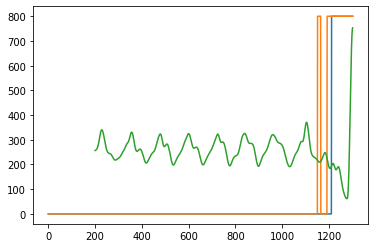

In [68]:
plt.plot(np.concatenate((zero, y)) * 800)
plt.plot(np.concatenate((zero, y_hat.reshape(-1))) * 800)
plt.plot(df.vm2)

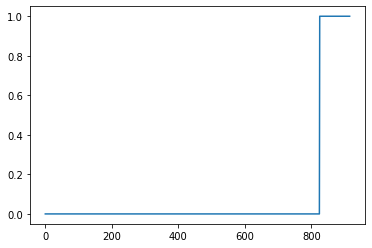

In [53]:
plt.plot(y)

In [ ]:
x.shape

In [ ]:
print('help me!!')